In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive") # Don't change this.
import os
my_path = "/eecs487project/" # THIS is your GDrive path
gdrive_path = "/content/drive" + "/MyDrive" + my_path
os.chdir(gdrive_path) # SETS os path as gdrive_path

Mounted at /content/drive


In [4]:
import json
import csv
import torch
import copy
import itertools
import time
import pandas as pd
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from FinalModel import *
from transformers import AdamW
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


P2

In [6]:
with open('labels.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    main_entity_labels = {row[0]: int(row[1]) for row in reader}

In [7]:
def sentence_finder(sen_id, paragraphs):
  run = 0
  for sentences in paragraphs:
    for sentence in sentences:
      if run == sen_id:
        return sentence
      run += 1

In [8]:
anno_list = []
for filestub in os.listdir("BASIL/articles"): # GETS EVERY YEAR
  for filename in os.listdir("BASIL/articles/" + filestub): # GETS EVERY ARTICLE PER YEAR
    file = os.path.splitext(filename)[0]
    with open(f"BASIL/annotations/{filestub}/{file}_ann.json") as ann, open(f"BASIL/articles/{filestub}/{file}.json") as art:
      annotation = json.load(ann) 
      article = json.load(art) 

    for phrase_anno in annotation["phrase-level-annotations"]:                                             # HERE CALCULATE ANNOTATION BIAS  
      if phrase_anno['polarity'] == 'pos':
        polarity = 1
      else:
        polarity = -1
      
      if phrase_anno['id'] != "title":
          sen_id = int(phrase_anno["id"][1:])
          sentence = sentence_finder(sen_id, article["body-paragraphs"])
          temp_dict = {"article": f"BASIL/articles/{filestub}/{file}.json","article_uuid": annotation['uuid'], "p_id": sen_id, "label": int(main_entity_labels[phrase_anno['target']]*polarity), "text": sentence, "source": article["source"]} 
          anno_list.append(temp_dict)
df = pd.DataFrame.from_records(anno_list)

In [9]:
# Final Data Cleaning and Augmentation
df.loc[df["label"] == -1.0, ["label"]] = 0.0 #Set -1 to 0 for BCEloss
df["text"] = df.text + " " + df.source

In [12]:
print(len(df))
print(len(df[df["label"]==0]))
print(len(df[df["label"]==1]))

1723
795
928


p3

In [13]:
train_df, rem = train_test_split(df, train_size=.7, stratify=df["label"])
valid_df, test_df = train_test_split(rem, train_size=.6, stratify=rem["label"])

In [ ]:
BaselineDataSet = MediaBiasDataset(train_df, valid_df, test_df, baseline=True)

In [ ]:
MobileDataSet = MediaBiasDataset(train_df, valid_df, test_df, baseline=False)

In [ ]:
def get_baseline_finetune_hyper_parameters():
    lr = [3e-5,5e-5, 7e-5]
    drop_out = [.1, .15, .2]

    return lr, drop_out

In [ ]:
def get_mobilebert_finetune_hyper_parameters():
    lr = [5e-4,6e-4,7e-4,8e-4]
    drop_out = [.12, .14]

    return lr, drop_out

In [ ]:
def search_param_finetune(DataSet, modelConstructor, get_hyper_parameters, epochs=5):
    """Experiemnt on different hyper parameters."""
    learning_rate, drop_out = get_hyper_parameters()
    print("learning rate from: {}\ndrop_out from: {}".format(
        learning_rate, drop_out
    ))
    loss_function = nn.BCEWithLogitsLoss()
    
    best_model, best_stats = None, None
    best_accuracy, best_lr = 0, 0
    for lr, dp in tqdm(itertools.product(learning_rate, drop_out), total=len(learning_rate)*len(drop_out)):
        net = modelConstructor(dp).to(device)
        optim = AdamW(net.parameters(),lr=lr)
        model, stats = finetune_model(net, DataSet, optim, loss_function, num_epoch=epochs, device=device, verbose=False)
        # print accuracy
        print(f"{lr}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_dp = dp
            best_lr = lr
    print("Best learning rate: {}".format(
        best_lr))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model

In [ ]:
def test_model(DataSet, model):
  model.eval()
  test_dataloader = BaselineDataSet.test_dataloader
  y_pred = []
  y_true = []
  with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=False, profile_memory=True) as prof:
      for b_input_ids, b_input_mask, b_labels  in test_dataloader:
          b_input_ids = b_input_ids.to(device)
          b_input_mask = b_input_mask.to(device)
          with record_function("model_inference"): 
            scores = model(b_input_ids,b_input_mask)
          preds = get_predictions(scores)
          y_pred.append(preds.cpu())
          y_true.append(b_labels)

  print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
  y_pred = torch.cat(y_pred)
  y_true = torch.cat(y_true)
  accuracy = (y_true == y_pred).sum() / y_pred.shape[0]
  return accuracy

learning rate from: [3e-05, 5e-05, 7e-05]
drop_out from: [0.1, 0.15, 0.2]


  0%|          | 0/9 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3e-05: 0.7096773982048035


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3e-05: 0.7064515948295593


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3e-05: 0.6838709712028503


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5e-05: 0.7129032015800476


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5e-05: 0.6903225779533386


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5e-05: 0.6870967745780945


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7e-05: 0.5387097001075745


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7e-05: 0.7032257914543152


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7e-05: 0.7064515948295593
Best learning rate: 5e-05
Accuracy: 0.7129


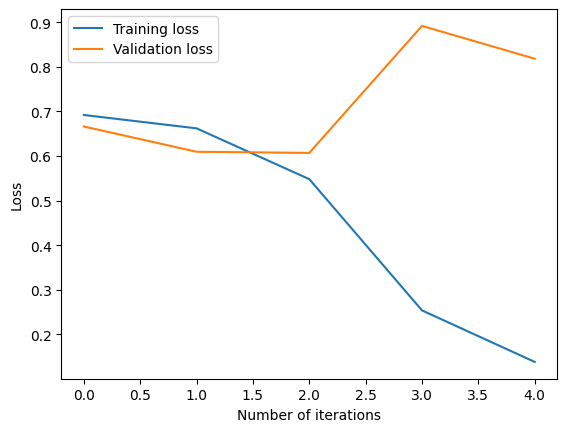

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::copy_         0.70%       8.178ms        74.86%     872.639ms       1.267ms      35.539ms         3.16%      53.977ms      78.341us           0 b           0 b           0 b           0 

In [ ]:
best_baseline = search_param_finetune(BaselineDataSet, BaselineClassifier, get_baseline_finetune_hyper_parameters)
print(test_model(BaselineDataSet, best_baseline))

learning rate from: [0.0005, 0.0006, 0.0007, 0.0008]
drop_out from: [0.12, 0.14]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0005: 0.6354838609695435


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0005: 0.5935483574867249


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0006: 0.5709677338600159


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0006: 0.6322580575942993


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0007: 0.6129032373428345


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0007: 0.551612913608551


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0008: 0.5387097001075745


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0008: 0.6161290407180786
Best learning rate: 0.0005
Accuracy: 0.6355


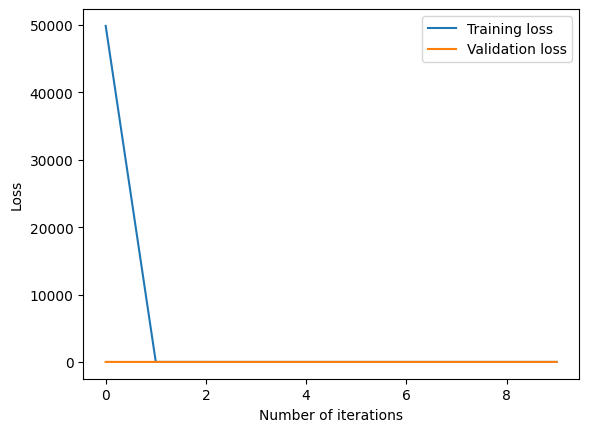

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        28.80%     296.710ms        98.28%        1.012s      77.875ms       0.000us         0.00%     379.277ms      29.175ms         192 b      -1.86 Kb     763.37 Mb     -21.41 G

In [ ]:
best_mobileModel = search_param_finetune(MobileDataSet, MobileBertClassifier, get_mobilebert_finetune_hyper_parameters, epochs=10)
print(test_model(MobileDataSet, best_mobileModel))